In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_name"] = working_dir.parent.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
data_results_dir = Path("../data/experiments-odin/adv/ss_us_01")

In [4]:
job_info_paths = list(data_results_dir.glob("**/job-info.json"))

In [5]:
df_raw_results = get_raw_results(job_info_paths)

In [6]:
grouping_cols = ["experiment_name", "epsilon", "k",  "algorithm_name", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,experiment_name,epsilon,k,algorithm_name,solution_type,distortion_mean,distortion_std,n_solutions
0,ss_us_01,0.01,10,sensitivity-sampling,adv0_33,1.020746,0.006480,250
1,ss_us_01,0.01,10,sensitivity-sampling,adv0_50,1.020835,0.007966,250
2,ss_us_01,0.01,10,sensitivity-sampling,adv0_67,1.020881,0.008996,250
3,ss_us_01,0.01,10,uniform-sampling,adv0_33,1.006674,0.005072,250
4,ss_us_01,0.01,10,uniform-sampling,adv0_50,1.007590,0.006163,250
...,...,...,...,...,...,...,...,...
115,ss_us_01,0.20,100,sensitivity-sampling,adv0_50,1.145647,0.018849,250
116,ss_us_01,0.20,100,sensitivity-sampling,adv0_67,1.145965,0.018701,250
117,ss_us_01,0.20,100,uniform-sampling,adv0_33,1.010374,0.007785,250
118,ss_us_01,0.20,100,uniform-sampling,adv0_50,1.010814,0.007963,250


In [7]:
pd.pivot(
    data=df_grouped,
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="distortion_mean"
)

algorithm_name                             sensitivity-sampling  \
experiment_name epsilon k   solution_type                         
ss_us_01        0.01    10  adv0_33                    1.020746   
                            adv0_50                    1.020835   
                            adv0_67                    1.020881   
                        20  adv0_33                    1.018387   
                            adv0_50                    1.018257   
                            adv0_67                    1.017783   
                        50  adv0_33                    1.015301   
                            adv0_50                    1.015101   
                            adv0_67                    1.015081   
                        70  adv0_33                    1.015238   
                            adv0_50                    1.015207   
                            adv0_67                    1.014825   
                        100 adv0_33                    1.016219   
                            adv0_50                    1.016100   
                            adv0_67                    1.015883   
                0.05    10  adv0_33                    1.090964   
                            adv0_50                    1.091580   
                            adv0_67                    1.089940   
                        20  adv0_33                    1.076324   
                            adv0_50                    1.075300   
                            adv0_67                    1.071812   
                        50  adv0_33                    1.066891   
                            adv0_50                    1.065475   
                            adv0_67                    1.061888   
                        70  adv0_33                    1.065514   
                            adv0_50                    1.064610   
                            adv0_67                    1.061497   
                        100 adv0_33                    1.059417   
                            adv0_50                    1.058151   
                            adv0_67                    1.056069   
                0.10    10  adv0_33                    1.146581   
                            adv0_50                    1.147364   
                            adv0_67                    1.147146   
                        20  adv0_33                    1.141680   
                            adv0_50                    1.137707   
                            adv0_67                    1.130431   
                        50  adv0_33                    1.107294   
                            adv0_50                    1.105799   
                            adv0_67                    1.102268   
                        70  adv0_33                    1.108138   
                            adv0_50                    1.107159   
                            adv0_67                    1.105359   
                        100 adv0_33                    1.096248   
                            adv0_50                    1.095438   
                            adv0_67                    1.094018   
                0.20    10  adv0_33                    1.276017   
                            adv0_50                    1.278748   
                            adv0_67                    1.282508   
                        20  adv0_33                    1.236128   
                            adv0_50                    1.240914   
                            adv0_67                    1.245024   
                        50  adv0_33                    1.177899   
                            adv0_50                    1.177405   
                            adv0_67                    1.177069   
                        70  adv0_33                    1.169145   
                            adv0_50                    1.169661   
                            adv0_67                    1.170544   
                        100 adv0_33            

In [8]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

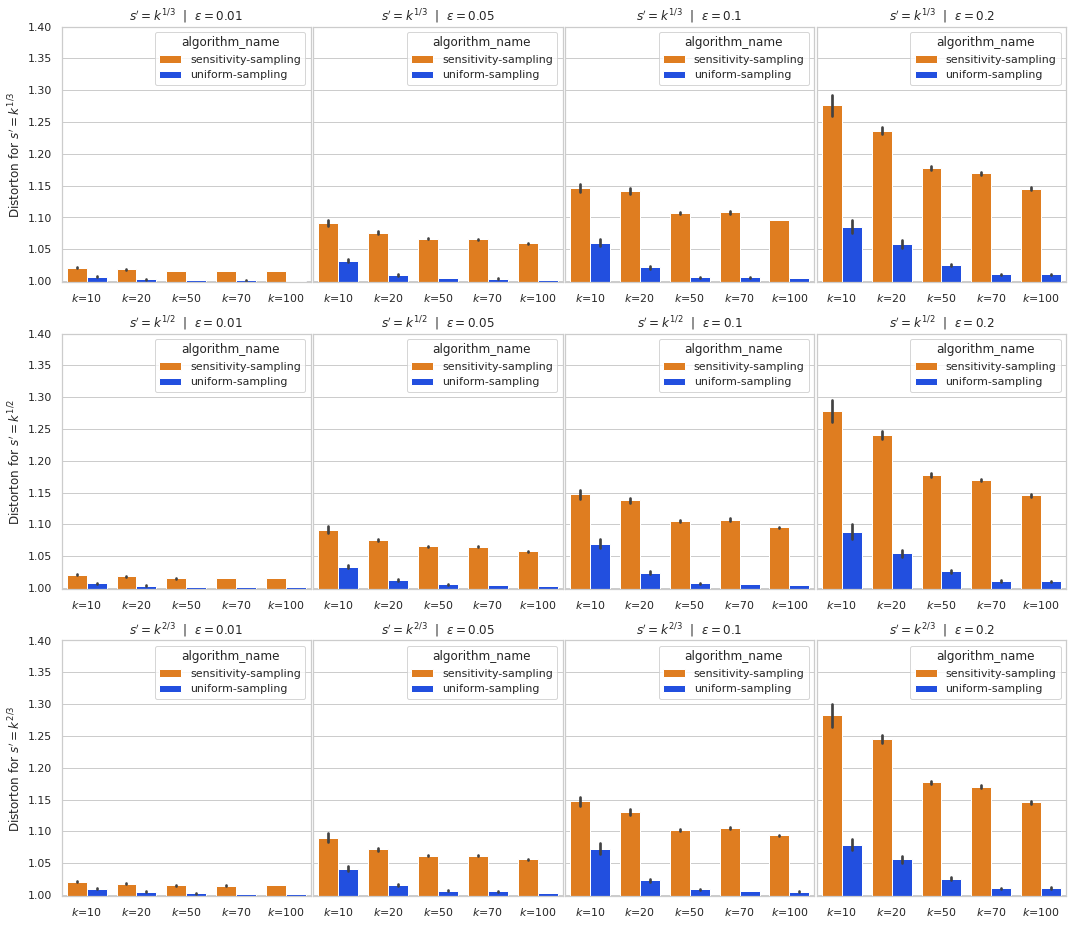

In [9]:
solution_types = np.sort(df_raw_results["solution_type"].unique())
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(18, 16))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998, top=1.4)
        ratio = {"adv0_50": "1/2", "adv0_33": "1/3", "adv0_67": "2/3"}[solution_type]
        s_prime = f"$s'=k^{{{ratio}}}$"
        ax.set_title(f"{s_prime}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {s_prime}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
#fig.savefig("distortions-adv-instance-v1.pdf", )